In [19]:
using DataFrames
using DifferentialEquations
using Plots

In [39]:
# TODO: Make this into a struct.
Base.@kwdef struct Parameters
    Δt::Float64  = 1e-3
    Cₘ::Float64  = 1.0
    gI::Float64  = 4.0    # nS
    gK::Float64  = 0.3    # nS
    gₕ::Float64  = 0.03   # nS
    gL::Float64  = 0.003  # nS
    gT::Float64  = 0.01   # nS
    gKC::Float64 = 0.03   # nS
    EI::Float64  = 30.0   # mV
    EK::Float64  = -75.0  # mV
    Eₕ::Float64  = 70.0   # mV
    EL::Float64  = -40.0  # mV
    ECa::Float64 = 140.0  # mV
    Kc::Float64  = 0.0085 # mV⁻¹
    τₓ::Float64  = 100.0  # ms, 235ms also used
    ρ::Float64   = 0.0003 # ms⁻¹
    Δx::Float64  = 0.0    # mm
    ΔCa::Float64 = 0.0    # ms
end
θ = Parameters()

LoadError: invalid redefinition of constant θ

In [21]:
Vₛ(V::Float64)::Float64 = (127.0 * V + 8265.0) / 105.0

Vₛ (generic function with 1 method)

In [22]:
function ɑₘ(V::Float64)::Float64
    Vs = Vₛ(V)
    0.1 * (50.0 - Vs)/(exp((50-Vs) / 10.0) - 1.0) # This minus was a plus in the paper. I found that it should be a minus by looking through the MATCONT melibeNew system equations.
end

βₘ(V::Float64)::Float64 = 4.0 * exp((25.0-Vₛ(V)) / 18.0)
m∞(V::Float64)::Float64 = ɑₘ(V) / (ɑₘ(V) + βₘ(V))
# Fast inward sodium and calcium current
II(θ, h::Float64, V::Float64)::Float64 = θ.gI * h * m∞(V)^3 * (V - θ.EI)

II (generic function with 1 method)

In [23]:
ɑₕ(V::Float64)::Float64 = 0.07 * exp((25.0 - Vₛ(V)) / 20.0)
βₕ(V::Float64)::Float64 = 1.0 / (1.0 + exp((55.0 - Vₛ(V)) / 10.0))
h∞(V::Float64)::Float64 = ɑₕ(V) / (ɑₕ(V) + βₕ(V))
τₕ(V::Float64)::Float64 = 12.5 / (ɑₕ(V) + βₕ(V))
Iₕ(θ, y::Float64, V::Float64)::Float64 = θ.gₕ * y * (V - θ.Eₕ) / (1.0 + exp((63.0 - V) / 7.8))^3
dh(h::Float64, V::Float64)::Float64 = (h∞(V) - h) / τₕ(V)

dh (generic function with 1 method)

In [24]:
function ɑₙ(V::Float64)::Float64
    Vs = Vₛ(V)
    0.01 * (55.0 - Vs) / (exp((55.0 - Vs) / 10.0) - 1.0)
end

βₙ(V::Float64)::Float64 = 0.125 * exp((45.0 - Vₛ(V)) / 80.0)
n∞(V::Float64)::Float64 = ɑₙ(V) / (ɑₙ(V) + βₙ(V))
τₙ(V::Float64)::Float64 = 12.5 / (ɑₙ(V) + βₙ(V))
IK(θ, n::Float64, V::Float64)::Float64 = θ.gK * n^4 * (V - θ.EK)
dn(θ, n::Float64, V::Float64)::Float64 = (n∞(V) - n) / τₙ(V)

dn (generic function with 1 method)

In [25]:
IT(θ, x::Float64, V::Float64)::Float64 = θ.gT * x * (V - θ.EI)

IT (generic function with 1 method)

In [26]:
IT(θ, x::Float64, V::Float64)::Float64 = θ.gT * x * (V - θ.EI)
x∞(θ, V::Float64)::Float64 = 1.0 / (1.0 + exp(0.15 * (θ.Δx - V - 50)))
dx(θ, x::Float64, V::Float64)::Float64 = (x∞(θ, V) - x) / θ.τₓ

dx (generic function with 1 method)

In [27]:
dy(θ, y::Float64, V::Float64)::Float64 = (1 / (1 + exp(10 * (V - 50))) - y) / (14.2 + 20.8 / (1 + exp((V + 68.0) / 2.2)))

dy (generic function with 1 method)

In [28]:
Iₗₑₐₖ(θ, V::Float64)::Float64 = θ.gL * (V - θ.EL)

Iₗₑₐₖ (generic function with 1 method)

In [29]:
IKCa(θ, Ca::Float64, V::Float64)::Float64 = θ.gKCa * Ca * (V - θ.EK) / (0.5 + Ca)
dCa(θ, Ca::Float64, x::Float64, V::Float64)::Float64 = θ["ρ"] * (θ.Kc * x * (θ.ECa - V + θ.ΔCa) - Ca)

dCa (generic function with 1 method)

In [30]:
function dV(θ, x::Float64, y::Float64, n::Float64, h::Float64, Ca::Float64, V::Float64, Isyn::Float64)::Float64
    -(II(θ, h, V) + IK(θ, n, V) + IT(θ, x, V) + IKCa(θ, Ca, V) + Iₕ(θ, y, V) + Iₗₑₐₖ(θ, V) + Isyn) / θ.Cₘ
end

dV (generic function with 1 method)

In [31]:
function melibeNew!(du, u, θ, t)
    x, y, n, h, Ca, V, Isyn = u
    du[1] = dx(θ, x, V)
    du[2] = dy(θ, y, V)
    du[3] = dn(θ, n, V)
    du[4] = dh(h, V)
    du[5] = dCa(θ, Ca, x, V)
    du[6] = dV(θ, x, y, n, h, Ca, V, Isyn)
    du[7] = 0.0
end

melibeNew! (generic function with 1 method)

In [32]:
Base.@kwdef mutable struct State
    x::Float64    = 0.7
    y::Float64    = 5.472e-46
    n::Float64    = 0.137
    h::Float64    = 0.389
    Ca::Float64   = 0.8
    V::Float64    = -62.0
    Isyn::Float64 = 0.0
end
state = State()

State(0.7, 5.472e-46, 0.137, 0.389, 0.8, -62.0, 0.0)

In [33]:
function step!(θ, state::State)
    state.x += θ.Δt * dx(θ, state.x, state.V)
    state.y += θ.Δt * dy(θ, state.y, state.V)
    state.n += θ.Δt * dn(θ, state.n, state.V)
    state.h += θ.Δt * dh(state.h, state.V)
    state.Ca += θ.Δt * dCa(θ, state.Ca, state.x, state.V)
    state.V += θ.Δt * dV(θ, state.x, state.y, state.n, state.h, state.Ca, state.V, state.Isyn)
end

step! (generic function with 1 method)

In [37]:
plt = plot(1, linewidth=2, xlabel="Ca", ylabel="x", legend=false);
pltV = plot(1, linewidth=2, xlabel="t", ylabel="mV", legend=false);

In [36]:
Cas = []
xs = []
Vs = []
for i in 1:3e7
    step!(θ, state)
    push!(Cas, state.Ca)
    push!(xs, state.x)
    push!(Vs, state.V)
    if i % 10000 == 0
        push!(plt, Cas, xs)
        push!(pltV, Vs)
        Cas = []
        xs = []
        Vs = []
    end
end

LoadError: type DataType has no field Δt

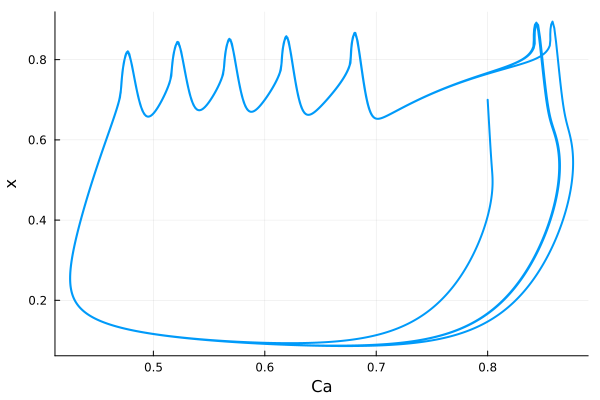

In [ ]:
plt

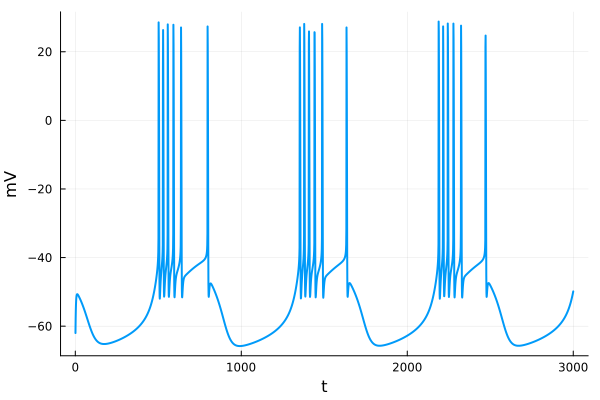

In [ ]:
pltV